* 由於要從眾多變因中找尋符合老師要求的正確率，我試圖利用有規劃性的方式找尋一些可能對結果有幫助的參數，得以建立我認為最佳的 RNN model。

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1.匯入資料庫

In [3]:
from keras.datasets import imdb

Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# 2.整理格式

## 輸入數據

In [5]:
print("訓練總筆數:", len(x_train))
print("測試總筆數:", len(x_test))

訓練總筆數: 25000
測試總筆數: 25000


In [6]:
from keras.preprocessing import sequence

In [7]:
# 把輸入文字變成一樣長(都上限為150字，不夠的補零)
x_train = sequence.pad_sequences(x_train, maxlen=150)
x_test = sequence.pad_sequences(x_test, maxlen=150)

# 檢查處理後的資料
x_train.shape

(25000, 150)

## 輸出數據

In [8]:
print("訓練總筆數:", len(y_train))
print("測試總筆數:", len(y_test))

訓練總筆數: 25000
測試總筆數: 25000


# 3.以 for loop 找到最佳的 K 值(固定 N = 100 )

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM

In [10]:
N = 100
best_acc = 0

for K in range(10, 100+1, 10):
    print(str(N)+", "+str(K))
        
    model = Sequential()
    
    model.add(Embedding(10000, N))
    model.add(LSTM(K))
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
      
    X0 = model.fit(x_train, y_train,
                   batch_size=100,
                   epochs=3)
        
    score = model.evaluate(x_test, y_test)
    print("acc = "+str(score[1]))
        
    if score[1] > best_acc:
        best_acc = score[1]
        best_K = K

100, 10
Epoch 1/3
25000/25000 [==============================] - 36s 1ms/step - loss: 0.4806 - acc: 0.7676
Epoch 2/3
25000/25000 [==============================] - 35s 1ms/step - loss: 0.2682 - acc: 0.8982
Epoch 3/3
25000/25000 [==============================] - 15s 585us/step
acc = 0.86164
100, 20
Epoch 1/3
25000/25000 [==============================] - 38s 2ms/step - loss: 0.4644 - acc: 0.7827
Epoch 2/3
25000/25000 [==============================] - 37s 1ms/step - loss: 0.2582 - acc: 0.8983
Epoch 3/3
25000/25000 [==============================] - 16s 621us/step
acc = 0.85744
100, 30
Epoch 1/3
25000/25000 [==============================] - 42s 2ms/step - loss: 0.4385 - acc: 0.7910
Epoch 2/3
25000/25000 [==============================] - 41s 2ms/step - loss: 0.2520 - acc: 0.9024
Epoch 3/3
25000/25000 [==============================] - 18s 714us/step
acc = 0.85272
100, 40
Epoch 1/3
25000/25000 [==============================] - ETA: 0s - loss: 0.4126 - acc: 0.802 - 46s 2ms/step - loss: 

In [11]:
print("best_K為"+str(best_K))
print("其對應正確率為"+str(best_acc))

best_K為80
其對應正確率為0.86244


由以上方法我們找到當 N = 100, K = 30 時，有最佳的 testing data 的正確率，但仍未達到老師要求的標準 87% ，所以以此為基礎進行一些調整看能不能優化它。

# 4.基於最佳的 model ，並且去優化它直到 testing data 的正確率達 87% 以上

為了避免 overfitting ，所以在此引進 EarlyStopping 和 Dropout 。

In [12]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [13]:
early_stopping = EarlyStopping(monitor='val_acc', verbose=2, mode='max', patience=1)

In [14]:
N = 100
K = best_K

model_best = Sequential()

early_stopping = EarlyStopping(monitor='val_acc', verbose=2, mode='max', patience=1)
model_best.add(Embedding(10000, N))
model_best.add(Dropout(0.25))
model_best.add(LSTM(K))
model_best.add(Dropout(0.2))
model_best.add(Dense(1, activation='sigmoid'))
        
model_best.compile(loss='binary_crossentropy', 
                   optimizer='adam',
                   metrics=['accuracy'])
        
X_best = model_best.fit(x_train, y_train,
                        validation_split=0.01,
                        batch_size=100,
                        epochs=10,
                        callbacks=[early_stopping])

Train on 24750 samples, validate on 250 samples
Epoch 1/10
24750/24750 [==============================] - 110s 4ms/step - loss: 0.4187 - acc: 0.7998 - val_loss: 0.2860 - val_acc: 0.8840
Epoch 2/10
24750/24750 [==============================] - 108s 4ms/step - loss: 0.2429 - acc: 0.9048 - val_loss: 0.3826 - val_acc: 0.8760
Epoch 00002: early stopping


## 檢視結果

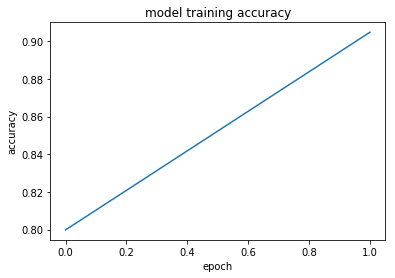

In [15]:
plt.plot(X_best.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [16]:
score = model_best.evaluate(x_test, y_test)
print("testing data 的正確率為"+str(score[1]))

25000/25000 [==============================] - 26s 1ms/step
testing data 的正確率為0.84844


# 5.以 for loop 找到最佳的 N 值(固定 K = 30 )

發現仍未達 87% 的正確率，所以我再對 N 進行修正。(雖然這些參數可能會彼此相依，但在此我們先將其視為參數彼此獨立)

In [17]:
K = 30
best_acc = 0

for N in range(10, 100+1, 10):
    print(str(N)+", "+str(K))
        
    model = Sequential()
    
    model.add(Embedding(10000, N))
    model.add(LSTM(K))
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
      
    X0 = model.fit(x_train, y_train,
                   batch_size=100,
                   epochs=3)
        
    score = model.evaluate(x_test, y_test)
    print("acc = "+str(score[1]))
        
    if score[1] > best_acc:
        best_acc = score[1]
        best_N = N

10, 30
Epoch 1/3
25000/25000 [==============================] - 20s 809us/step - loss: 0.4819 - acc: 0.7602
Epoch 2/3
25000/25000 [==============================] - 19s 742us/step - loss: 0.2613 - acc: 0.8979
Epoch 3/3
25000/25000 [==============================] - 9s 366us/step
acc = 0.84492
20, 30
Epoch 1/3
25000/25000 [==============================] - 23s 914us/step - loss: 0.4796 - acc: 0.7573
Epoch 2/3
25000/25000 [==============================] - 21s 842us/step - loss: 0.2588 - acc: 0.8980
Epoch 3/3
25000/25000 [==============================] - 10s 390us/step
acc = 0.85364
30, 30
Epoch 1/3
25000/25000 [==============================] - 26s 1ms/step - loss: 0.4462 - acc: 0.7881
Epoch 2/3
25000/25000 [==============================] - 24s 959us/step - loss: 0.2508 - acc: 0.9017
Epoch 3/3
25000/25000 [==============================] - 11s 426us/step
acc = 0.85636
40, 30
Epoch 1/3
25000/25000 [==============================] - 28s 1ms/step - loss: 0.4436 - acc: 0.7911
Epoch 2/3
25

In [18]:
print("best_N為"+str(best_N))
print("其對應正確率為"+str(best_acc))

best_N為40
其對應正確率為0.8616


# 6.基於最佳的 model ，並且去優化它直到 testing data 的正確率達 87% 以上

In [19]:
N = best_N
K = best_K

model_best = Sequential()

early_stopping = EarlyStopping(monitor='val_acc', verbose=2, mode='max', patience=1)
model_best.add(Embedding(10000, N))
model_best.add(Dropout(0.25))
model_best.add(LSTM(K))
model_best.add(Dropout(0.2))
model_best.add(Dense(1, activation='sigmoid'))
        
model_best.compile(loss='binary_crossentropy', 
                   optimizer='adam',
                   metrics=['accuracy'])
        
X_best = model_best.fit(x_train, y_train,
                        validation_split=0.01,
                        batch_size=100,
                        epochs=10,
                        callbacks=[early_stopping])

Train on 24750 samples, validate on 250 samples
Epoch 1/10
24750/24750 [==============================] - 70s 3ms/step - loss: 0.4552 - acc: 0.7727 - val_loss: 0.3034 - val_acc: 0.8680
Epoch 2/10
24750/24750 [==============================] - 67s 3ms/step - loss: 0.2589 - acc: 0.8977 - val_loss: 0.2726 - val_acc: 0.8720
Epoch 3/10
24750/24750 [==============================] - 67s 3ms/step - loss: 0.2029 - acc: 0.9253 - val_loss: 0.2858 - val_acc: 0.8880
Epoch 4/10
24750/24750 [==============================] - 67s 3ms/step - loss: 0.1692 - acc: 0.9404 - val_loss: 0.3517 - val_acc: 0.8680
Epoch 00004: early stopping


## 檢視結果

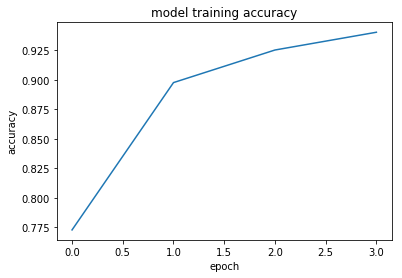

In [20]:
plt.plot(X_best.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [21]:
score = model_best.evaluate(x_test, y_test)
print("testing data 的正確率為"+str(score[1]))

25000/25000 [==============================] - 21s 832us/step
testing data 的正確率為0.8386


結果反而變低了...或許我們可以再調整 batch_size 看會對結果造成什麼影響。

# 7.以 for loop 找到最佳的 batch_size值(固定 N = 20, K = 30 )

In [22]:
N = best_N
K = best_K
best_acc = 0

for Size in range(150, 500+1, 50):
    print("Size: "+str(Size))
        
    model = Sequential()
    
    model.add(Embedding(10000, N))
    model.add(LSTM(K))
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
      
    X0 = model.fit(x_train, y_train,
                   batch_size=Size,
                   epochs=3)
        
    score = model.evaluate(x_test, y_test)
    print("acc = "+str(score[1]))
        
    if score[1] > best_acc:
        best_acc = score[1]
        best_Size = Size

Size: 150
Epoch 1/3
25000/25000 [==============================] - 83s 3ms/step - loss: 0.4443 - acc: 0.7842
Epoch 2/3
25000/25000 [==============================] - 81s 3ms/step - loss: 0.2516 - acc: 0.9028
Epoch 3/3
25000/25000 [==============================] - 22s 876us/step
acc = 0.85444
Size: 200
Epoch 1/3
25000/25000 [==============================] - 78s 3ms/step - loss: 0.4783 - acc: 0.7578
Epoch 2/3
25000/25000 [==============================] - 76s 3ms/step - loss: 0.2557 - acc: 0.9005
Epoch 3/3
25000/25000 [==============================] - 22s 885us/step
acc = 0.86036
Size: 250
Epoch 1/3
25000/25000 [==============================] - 101s 4ms/step - loss: 0.4999 - acc: 0.7378
Epoch 2/3
25000/25000 [==============================] - 103s 4ms/step - loss: 0.2754 - acc: 0.8893
Epoch 3/3
25000/25000 [==============================] - 23s 902us/step
acc = 0.85996
Size: 300
Epoch 1/3
25000/25000 [==============================] - 100s 4ms/step - loss: 0.5400 - acc: 0.7226
Epoch 

In [23]:
print("best_Size為"+str(best_Size))
print("其對應正確率為"+str(best_acc))

best_Size為450
其對應正確率為0.86392


# 8.基於最佳的 model ，並且去優化它直到 testing data 的正確率達 87% 以上

In [24]:
N = best_N
K = best_K
Size = best_Size

model_best = Sequential()

early_stopping = EarlyStopping(monitor='val_acc', verbose=2, mode='max', patience=1)
model_best.add(Embedding(10000, N))
model_best.add(Dropout(0.25))
model_best.add(LSTM(K))
model_best.add(Dropout(0.2))
model_best.add(Dense(1, activation='sigmoid'))
        
model_best.compile(loss='binary_crossentropy', 
                   optimizer='adam',
                   metrics=['accuracy'])
        
X_best = model_best.fit(x_train, y_train,
                        validation_split=0.01,
                        batch_size=Size,
                        epochs=10,
                        callbacks=[early_stopping])

Train on 24750 samples, validate on 250 samples
Epoch 1/10
24750/24750 [==============================] - 147s 6ms/step - loss: 0.6066 - acc: 0.6508 - val_loss: 0.3928 - val_acc: 0.8520
Epoch 2/10
24750/24750 [==============================] - 145s 6ms/step - loss: 0.3190 - acc: 0.8697 - val_loss: 0.2782 - val_acc: 0.9000
Epoch 3/10
24750/24750 [==============================] - 144s 6ms/step - loss: 0.2292 - acc: 0.9118 - val_loss: 0.2884 - val_acc: 0.8840
Epoch 00003: early stopping


## 檢視結果

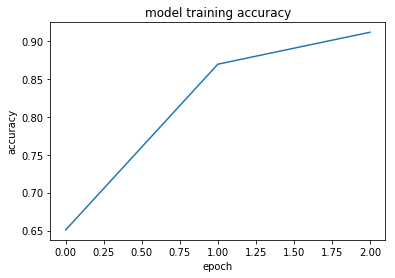

In [25]:
plt.plot(X_best.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [26]:
score = model_best.evaluate(x_test, y_test)
print("testing data 的正確率為"+str(score[1]))

25000/25000 [==============================] - 22s 890us/step
testing data 的正確率為0.8616


雖然有很小幅的上升了，很可惜的仍然沒有達要求...因此想回頭看看是否與一開始的 maxlen 長度有關。

# 9.以 for loop 找到最佳的 maxlen 值(固定 N = 20, K = 30, batch_size = 450 )

In [27]:
N = best_N
K = best_K
Size = best_Size
best_acc = 0

for MLen in range(150, 200+1, 10):
    # 把輸入文字變成一樣長(都上限為150字，不夠的補零)
    x_train = sequence.pad_sequences(x_train, maxlen=MLen)
    x_test = sequence.pad_sequences(x_test, maxlen=MLen)
    
    print("Maxlen: "+str(MLen))
        
    model = Sequential()
    
    model.add(Embedding(10000, N))
    model.add(LSTM(K))
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
      
    X0 = model.fit(x_train, y_train,
                   batch_size=Size,
                   epochs=3)
        
    score = model.evaluate(x_test, y_test)
    print("acc = "+str(score[1]))
        
    if score[1] > best_acc:
        best_acc = score[1]
        best_MLen = MLen

Maxlen: 150
Epoch 1/3
25000/25000 [==============================] - 145s 6ms/step - loss: 0.5707 - acc: 0.6904
Epoch 2/3
25000/25000 [==============================] - 142s 6ms/step - loss: 0.2913 - acc: 0.8824
Epoch 3/3
25000/25000 [==============================] - 24s 956us/step
acc = 0.86432
Maxlen: 160
Epoch 1/3
25000/25000 [==============================] - 154s 6ms/step - loss: 0.5829 - acc: 0.6888
Epoch 2/3
25000/25000 [==============================] - 152s 6ms/step - loss: 0.2981 - acc: 0.8831
Epoch 3/3
25000/25000 [==============================] - 26s 1ms/step
acc = 0.86208
Maxlen: 170
Epoch 1/3
25000/25000 [==============================] - 166s 7ms/step - loss: 0.6574 - acc: 0.6140
Epoch 2/3
25000/25000 [==============================] - 164s 7ms/step - loss: 0.3554 - acc: 0.8509
Epoch 3/3
25000/25000 [==============================] - 27s 1ms/step
acc = 0.86648
Maxlen: 180
Epoch 1/3
25000/25000 [==============================] - 182s 7ms/step - loss: 0.6285 - acc: 0.651

In [28]:
print("best_MLen為"+str(best_MLen))
print("其對應正確率為"+str(best_acc))

best_MLen為200
其對應正確率為0.86676


# 10.基於最佳的 model ，並且去優化它直到 testing data 的正確率達 87% 以上

In [29]:
N = best_N
K = best_K
Size = best_Size
MLen = best_MLen
best_acc = 0

x_train = sequence.pad_sequences(x_train, maxlen=MLen)
x_test = sequence.pad_sequences(x_test, maxlen=MLen) 

model_best = Sequential()

early_stopping = EarlyStopping(monitor='val_acc', verbose=2, mode='max', patience=1)
model_best.add(Embedding(10000, N))
model_best.add(Dropout(0.25))
model_best.add(LSTM(K))
model_best.add(Dropout(0.2))
model_best.add(Dense(1, activation='sigmoid'))
        
model_best.compile(loss='binary_crossentropy', 
                   optimizer='adam',
                   metrics=['accuracy'])
        
X_best = model_best.fit(x_train, y_train,
                        validation_split=0.01,
                        batch_size=Size,
                        epochs=10,
                        callbacks=[early_stopping])

Train on 24750 samples, validate on 250 samples
Epoch 1/10
24750/24750 [==============================] - 234s 9ms/step - loss: 0.6705 - acc: 0.6195 - val_loss: 0.6503 - val_acc: 0.7360
Epoch 2/10
24750/24750 [==============================] - 234s 9ms/step - loss: 0.5446 - acc: 0.7733 - val_loss: 0.3619 - val_acc: 0.8560
Epoch 3/10
24750/24750 [==============================] - 235s 9ms/step - loss: 0.3001 - acc: 0.8781 - val_loss: 0.2954 - val_acc: 0.8800
Epoch 4/10
24750/24750 [==============================] - 235s 9ms/step - loss: 0.2236 - acc: 0.9154 - val_loss: 0.2834 - val_acc: 0.8720
Epoch 00004: early stopping


## 檢視結果

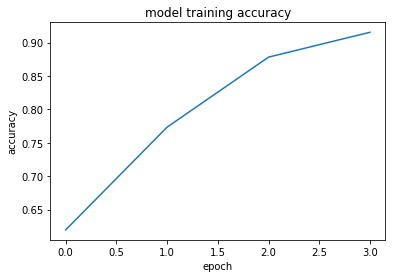

In [30]:
plt.plot(X_best.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [31]:
score = model_best.evaluate(x_test, y_test)
print("testing data 的正確率為"+str(score[1]))

25000/25000 [==============================] - 31s 1ms/step
testing data 的正確率為0.8648


## 儲存

In [32]:
model_best_json = model_best.to_json()
open("N"+str(N)+"K"+str(K)+"RNN_for_HW"+".json", 'w').write(model_best_json)
model_best.save_weights("N"+str(N)+"K"+str(K)+"RNN_for_HW_weights.h5")

# 心得

* 基於上課建構的模型，我對此進行幾項數值(N, K, batch_size, maxlen)最佳化的測試，試圖使最後 testing data 的正確率達到老師要求的 87% 。
* 在尋找最佳化的值時，我做了一個假設：各個變因彼此不相關(這"極為"可能是個錯誤的假設，但對於現階段我能做到的只能利用此方法提高正確率)。
* 由第 3~6 點我們可以發現，並非越大的 N 及 K 值(甚至最後得到的數值還偏小)會達到最佳的結果。
* 由第 7~8 點我們可以發現，batch_size 的數值似乎不能太小，否則會造成正確率上升緩慢或是變小。
* 由第9~10 點藉由改變 maxlen 的大小，試圖選用最有能能提高正確率的參數，由結果可以發現 maxlen 太大正確率會往下掉。

# 結果呈現

In [34]:
print("N = "+str(best_N)+", " +"K = "+str(best_K)+", "+"batch_size = "+str(best_Size)+", "+"maxlen = "+ str(MLen))

N = 40, K = 80, batch_size = 450, maxlen = 200
